In [1]:
%load_ext processingpymat

In [2]:
%matplotlib nbagg

In [18]:
from Tankgame.tankai import TankAI, Operation
from Tankgame.ai import AI

class RandomAI(TankAI):
    def __init__(self, name='Unknown'):
        super().__init__(name)
        self.ai = None
        self.ops = None
    
    def perform(self, env):
        print('Tanks', env.heroes)
        if self.ai is None:
            self.ai = [AI(10) for h in env.heroes]
            self.ops = [Operation() for h in env.heroes]
        for ai, op in zip(self.ai, self.ops):
            ai.move(op)
        return self.ops

In [19]:
import math
from Tankgame.tankai import TankAI, Operation
from Tankgame.ai import AI

class DivideAI(TankAI):
    def __init__(self, name='Unknown'):
        super().__init__(name)
        self.current_enemy_id = None
    
    def perform(self, env):
        ops = []
        # 攻撃対象の敵を判定
        if self.current_enemy_id is None:
            enemy = None
            alives = [e for e in env.enemies if not e.dead]
            self.current_enemy_id = alives[0].id if len(alives) > 0 else None
            if len(alives) > 0:
                enemy = alives[0]
        else:
            enemies = [e for e in env.enemies if e.id == self.current_enemy_id]
            enemy = enemies[0] if len(enemies) > 0 else None
            if enemy.dead:
                # 破壊済み ... 次の対象を決定
                alives = [e for e in env.enemies if not e.dead]
                self.current_enemy_id = alives[0].id if len(alives) > 0 else None
        
        for i, hero in enumerate(env.heroes):
            op = Operation()
            ops.append(op)
            if enemy is None:
                # 敵が見えない... 回りながら待機を続ける
                op.key_turn_right = True
                continue
            
            # 自機を敵の方へと向かせる
            # (1)自機からみて敵がどの角度に位置しているかを計算
            dx = enemy.x - hero.x
            dy = enemy.y - hero.y
            enemy_angle = math.atan2(dy, dx) / math.pi * 180 # ラジアンから度に変換
            
            # (2)現在の角度との差分を計算
            # hero.body_rot が戦車の向いている角度 ... 0度ならばマップ右を向いている, +ならば時計回り方向, -ならば反時計回り
            # math.atan2で計算した角度とは符号を反転する(回転方向を逆にする)必要がある
            diff_angle = enemy_angle - hero.body_rot
            if diff_angle < 0:
                op.key_turn_left = True
            elif diff_angle > 0:
                op.key_turn_right = True
            if abs(diff_angle) > 45:
                # 角度が一定以上ずれていたら進行はしない
                op.key_drive = False
                op.key_reverse = False
                continue
            print((self.name, hero.body_rot, enemy_angle, diff_angle))
            
            #  敵との距離を一定間隔に維持する
            dist = math.sqrt(dx * dx + dy * dy)
            if dist > 100:
                print(self.name, dist)
                op.key_drive = True
            elif dist < 50:
                op.key_reverse = True
            # 撃ち続ける
            op.key_shoot = True
        return ops

In [20]:
hero_ai = DivideAI('Legion A')
enemy_ai = RandomAI('Legion B')

In [21]:
class Manager:
    def __init__(self):
        self.logs = []
        
    def reset(self):
        self.logs = []
    
    def log(self, world, heroes, enemies, bullets):
        self.logs.append((world.copy(), [h.copy() for h in heroes], [e.copy() for e in enemies], [b.copy() for b in bullets]))
        
    def get_frames(self):
        count = 0
        while len(self.logs) == 0 or (any([not t.dead for t in self.logs[-1][1]]) and any([not t.dead for t in self.logs[-1][2]])):
            count += 1
            yield count

In [22]:
manager = Manager()

<IPython.core.display.Javascript object>


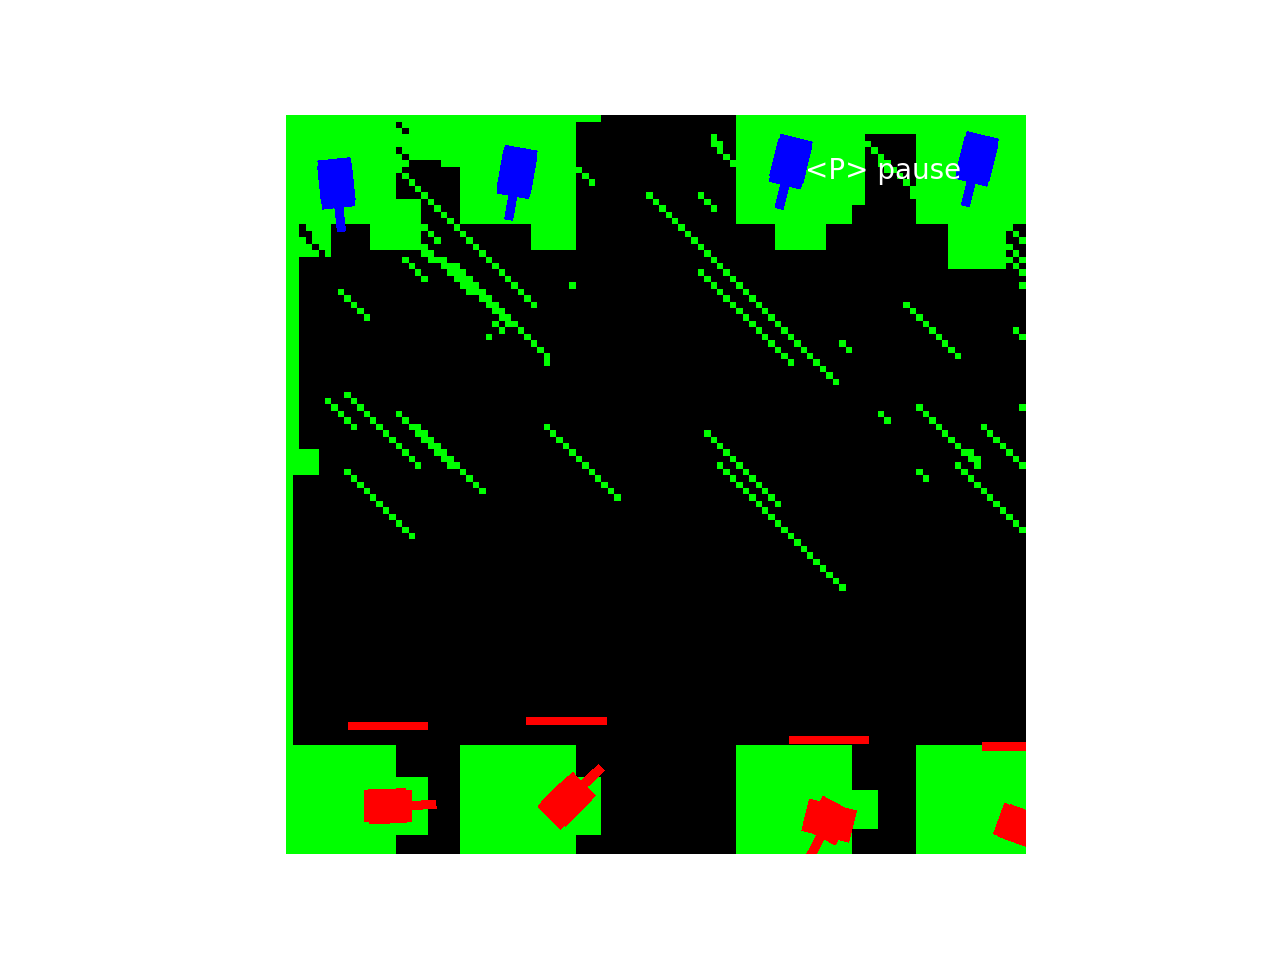

(<processingpymat.processing.Processing at 0x7f1f85f005d0>,
 <matplotlib.animation.FuncAnimation at 0x7f1f86692c50>)

In [25]:
%%processing skipframes=9
import traceback
from Tankgame.env import Environment
from Tankgame.world import World
from Tankgame.tank import Tank
from Tankgame.target import Target
from Tankgame.ai import AI
from Tankgame.ui import UI

bullets = []

def setup():
    global grid, target, world, heroes, enemies, ui

    size(460, 460, P2D)
    noSmooth()

    ui = UI()

    world = World(width, height, 4)
    world.create_grid()

    heroes = []
    for tankx in [30, width // 4 + 30, width // 4 * 3 - 30, width - 30]:
        tank = Tank(tankx, 30, bullets, ui, True)
        world.destroy(70, tank.x, tank.y)
        heroes.append(tank)

    enemies = []
    for tankx in [30, width // 4 + 30, width // 4 * 3 - 30, width - 30]:
        enemy = Tank(tankx, height - 30, bullets, ui, False)
        world.destroy(70,  enemy.x, enemy.y)
        enemies.append(enemy)

    noStroke()
    
    # Start game automatically
    ui.state = ui.gameplay


def draw():
    global bullets, world, heroes, enemies, ui

    #background(200, 255, 100)
    background(0, 255, 0)

    world.render()
    
    try:
        hero_ops = hero_ai.perform(Environment(world, heroes, enemies, bullets))
        for tank, op in zip(heroes, hero_ops):
            op.applyTo(tank)
    except:
        textAlign(CENTER)
        fill(255)
        text('ERROR', heroes[0].real_x, heroes[0].real_y)
        traceback.print_exc()
    try:
        enemy_ops = enemy_ai.perform(Environment(world, enemies, heroes, bullets))
        for tank, op in zip(enemies, enemy_ops):
            op.applyTo(tank)
    except:
        textAlign(CENTER)
        fill(255)
        text('ERROR', heroes[0].real_x, heroes[0].real_y)
        traceback.print_exc()

    for tank in heroes:
        if ui.state == ui.gameplay:
            tank.update(world)
        tank.render(False)

    for enemy in enemies:
        if ui.state == ui.gameplay:
            enemy.update(world)
        enemy.render(False)

    destroyed = []
    for i, bullet in enumerate(bullets):

        destroy = False

        if bullet.x < 0 or bullet.x > width or bullet.y < 0 or bullet.y > height:
            destroy = True
        else:

            for tank in heroes:
                if bullet.x > tank.x-tank._height/2 and bullet.x < tank.x+tank._height/2 and bullet.y > tank.y-tank._height/2 and bullet.y < tank.y+tank._height/2:
                    tank.hit()
                    destroy = True
                    continue

            for enemy in enemies:

                if bullet.x > enemy.x-enemy._height/2 and bullet.x < enemy.x+enemy._height/2 and bullet.y > enemy.y-enemy._height/2 and bullet.y < enemy.y+enemy._height/2:
                    enemy.hit()
                    destroy = True
                    continue

            if world.grid[min(int(bullet.y / world.cell_size), len(world.grid) - 1)][min(int(bullet.x / world.cell_size), len(world.grid[0]) - 1)] == 1:

                world.destroy(int(random(20, 40)), int(bullet.x), int(bullet.y))
                destroy = True

        if destroy:
            destroyed.append(i)
            continue

        if ui.state == ui.gameplay:
            bullet.update()
        bullet.render()
        
    for d in destroyed[::-1]:
        bullets.pop(d)
    manager.log(world, heroes, enemies, bullets)

    ui.render()

In [17]:
proc = %lastprocess
manager.reset()
proc.generate(frames=manager.get_frames, skipframes=59, debug=True)

<IPython.core.display.Javascript object>

/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


Draw(frame=1, skipframe=0): duration=0.005235 seconds.
Draw(frame=1, skipframe=1): duration=0.008584 seconds.
Draw(frame=1, skipframe=2): duration=0.009371 seconds.
Draw(frame=1, skipframe=3): duration=0.018589 seconds.
Draw(frame=1, skipframe=4): duration=0.010693 seconds.
Draw(frame=1, skipframe=5): duration=0.006933 seconds.
Draw(frame=1, skipframe=6): duration=0.005905 seconds.
Draw(frame=1, skipframe=7): duration=0.010262 seconds.
Draw(frame=1, skipframe=8): duration=0.004614 seconds.
Draw(frame=1, skipframe=9): duration=0.007573 seconds.
Draw(frame=1, skipframe=10): duration=0.004582 seconds.
Draw(frame=1, skipframe=11): duration=0.00416 seconds.
Draw(frame=1, skipframe=12): duration=0.007052 seconds.
Draw(frame=1, skipframe=13): duration=0.006114 seconds.
Draw(frame=1, skipframe=14): duration=0.004746 seconds.
Draw(frame=1, skipframe=15): duration=0.004406 seconds.
Draw(frame=1, skipframe=16): duration=0.00398 seconds.
Draw(frame=1, skipframe=17): duration=0.004693 seconds.
Draw

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '1.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpstj_eb9f/temp.m4v']' returned non-zero exit status 255.

In [33]:
len(manager.logs)

2280

<IPython.core.display.Javascript object>


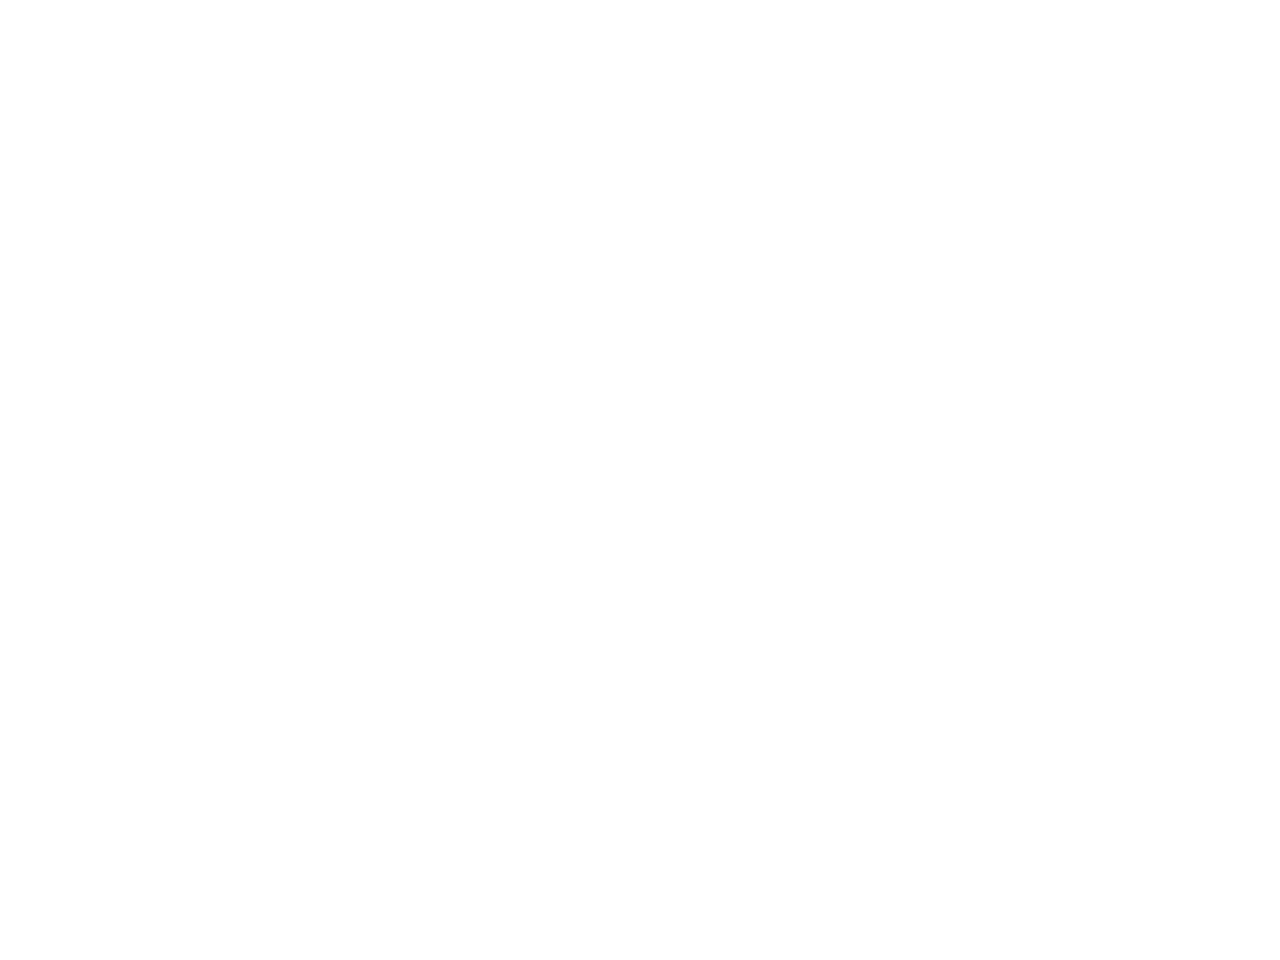

/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


(<processingpymat.processing.Processing at 0x7fb01f144150>,
 <matplotlib.animation.FuncAnimation at 0x7fb027b11510>)

In [34]:
%%processing skipframes=4
def setup():
    size(460, 460, P2D)
    noSmooth()
    noStroke()
    
    global frame
    frame = 0


def draw():
    global frame

    #background(200, 255, 100)
    background(0, 255, 0)
    
    if frame >= len(manager.logs):
        return

    world, heroes, enemies, bullets = manager.logs[frame]
    
    frame += 1

    world.render()

    for tank in heroes:
        tank.render(False)

    for enemy in enemies:
        enemy.render(False)

    for bullet in bullets:
        bullet.render()

<IPython.core.display.Javascript object>


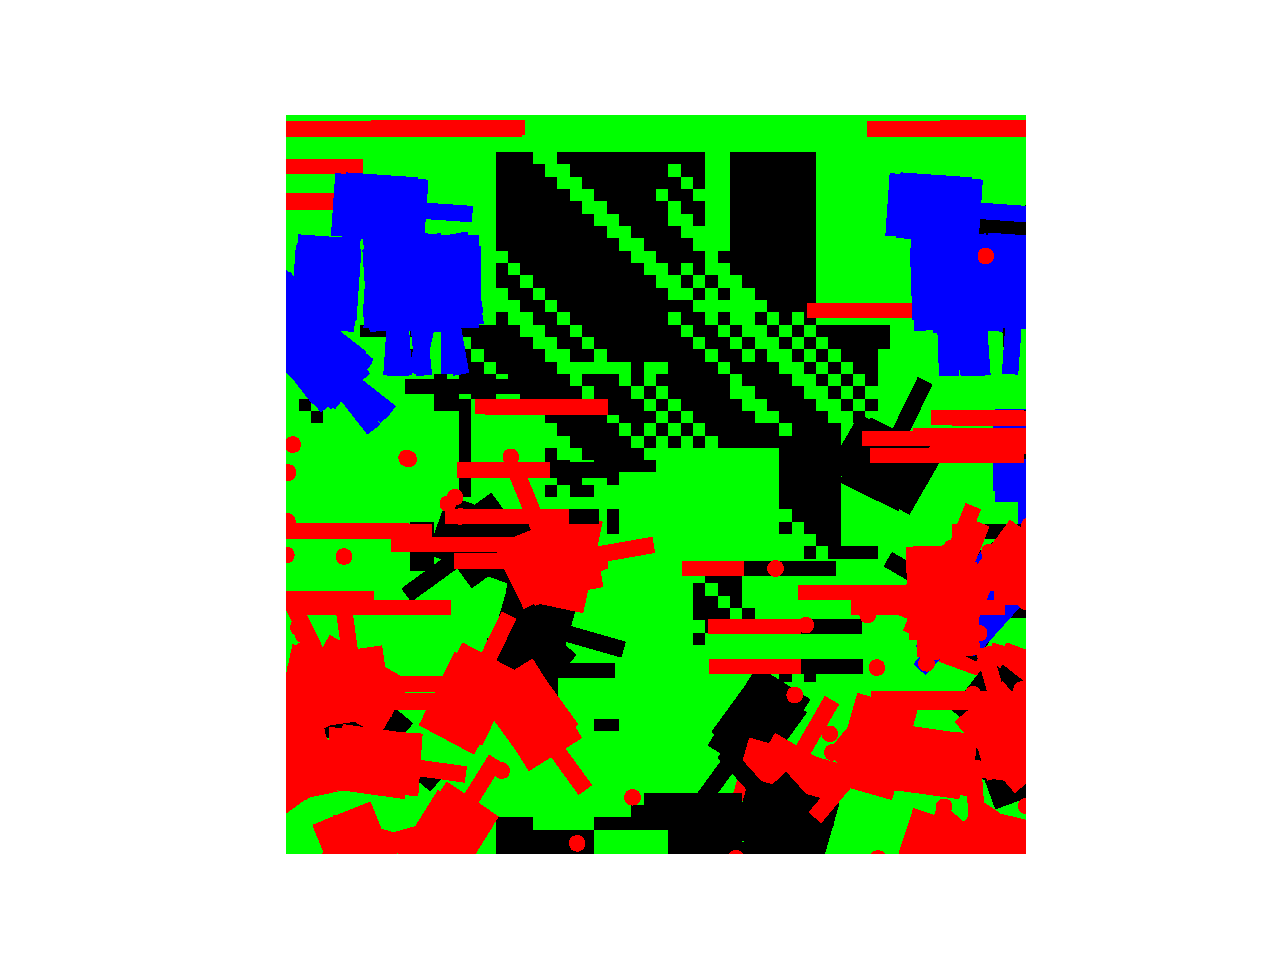

Draw(frame=0): duration=2.157847 seconds.
Draw(frame=0): duration=0.021876 seconds.
Draw(frame=1, skipframe=0): duration=0.000837 seconds.
Draw(frame=1, skipframe=1): duration=0.000825 seconds.
Draw(frame=1, skipframe=2): duration=0.000734 seconds.
Draw(frame=1, skipframe=3): duration=0.000819 seconds.
Draw(frame=1): duration=0.067848 seconds.
Draw(frame=2, skipframe=0): duration=0.000817 seconds.
Draw(frame=2, skipframe=1): duration=0.00072 seconds.
Draw(frame=2, skipframe=2): duration=0.000693 seconds.
Draw(frame=2, skipframe=3): duration=0.000787 seconds.
Draw(frame=2): duration=0.026398 seconds.
Draw(frame=3, skipframe=0): duration=0.001619 seconds.
Draw(frame=3, skipframe=1): duration=0.001398 seconds.
Draw(frame=3, skipframe=2): duration=0.001425 seconds.
Draw(frame=3, skipframe=3): duration=0.00135 seconds.
Draw(frame=3): duration=0.034369 seconds.
Draw(frame=4, skipframe=0): duration=0.001415 seconds.
Draw(frame=4, skipframe=1): duration=0.001542 seconds.
Draw(frame=4, skipfram

In [35]:
proc = %lastprocess
proc.generate(frames=len(manager.logs), skipframes=4, debug=True)